In [1]:
import os

import pandas as pd
import keras
import pickle
import pumpp
from pescador.maps import buffer_stream, keras_tuples
from sklearn.model_selection import ShuffleSplit

from workspace import construct_model, make_sampler, data_generator, val_generator, val_sampler
import train_utils

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()

W0915 21:12:26.810548 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0915 21:12:26.867748 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0915 21:12:26.870887 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
DATA_HOME = "/Users/tom/Music/GuitarSet/"
OUTPUT_PATH = 'resources'
working = '/Users/tom/Music/GS_features/'
max_samples = 8
duration = 12
poisson_rate = 4
batch_size = 16
epochs = 512
epoch_size = 64
reduce_lr = 8
early_stopping = 32
seed = 20190902

In [4]:
pump = train_utils.make_pump()

W0915 21:12:28.669138 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 21:12:28.698042 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0915 21:12:28.796871 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [5]:
# Build the model
model, inputs, outputs = construct_model(pump)

In [14]:
# Build the sampler
sampler = make_sampler(max_samples, duration, pump, seed)

track_index = pd.read_json('guitarset_index.json')
track_ids = [k + '_mic' for k in track_index.keys()]

# Split the data into train val
splitter_tv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, val_idx = next(splitter_tv.split(track_ids))
train_track_ids = [track_ids[idx] for idx in train_idx]
val_track_ids = [track_ids[idx] for idx in val_idx]

In [19]:
import json

with open('val_track_ids.json', 'w') as fp:
    json.dump(val_track_ids, fp)


In [7]:
gen_train = data_generator(working, train_track_ids, sampler, epoch_size,
                           augment=False,
                           rate=poisson_rate,
                           mode='with_replacement',
                           random_state=seed)

gen_train = keras_tuples(buffer_stream(gen_train(), batch_size, axis=0),
                         inputs=inputs,         
                         outputs=outputs)

In [8]:
gen_val = val_generator(working, val_track_ids, augment=False)
validation_size = gen_val.n_streams

gen_val = keras_tuples(gen_val(), inputs=inputs, outputs=outputs)

In [9]:
loss = {'key_tag': 'sparse_categorical_crossentropy'}
metrics = {'key_tag': 'sparse_categorical_accuracy'}

loss.update(key_profile='binary_crossentropy',
            key_tonic='sparse_categorical_crossentropy')

monitor = 'val_key_tag_sparse_categorical_accuracy'

#sgd = K.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
model.compile(adam, loss=loss, metrics=metrics)

# Store the model
model_spec = keras.utils.serialize_keras_object(model)
with open(os.path.join(OUTPUT_PATH, 'model_spec.pkl'), 'wb') as fd:
    pickle.dump(model_spec, fd)

# Construct the weight path
weight_path = os.path.join(OUTPUT_PATH, 'model.h5')

# Build the callbacks
cb = []
cb.append(keras.callbacks.ModelCheckpoint(weight_path,
                                          save_best_only=True,
                                          verbose=1,
                                          monitor=monitor))

cb.append(keras.callbacks.ReduceLROnPlateau(patience=reduce_lr,
                                            verbose=1,
                                            monitor=monitor))

cb.append(keras.callbacks.EarlyStopping(patience=early_stopping,
                                        verbose=1,
                                        monitor=monitor))

cb.append(keras.callbacks.TensorBoard(log_dir='./logs/run1', batch_size=batch_size, update_freq='batch'))

W0915 21:12:47.556123 4607870400 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 21:12:47.670876 4607870400 deprecation.py:323] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
history = model.fit_generator(gen_train, epoch_size, epochs,
                              validation_data=gen_val,
                              validation_steps=validation_size,
                              callbacks=cb)

Instructions for updating:
Use tf.cast instead.
Epoch 1/512
64/64 [==============================] - 34s 524ms/step - loss: 4.4342 - key_tag_loss: 2.2892 - key_tonic_loss: 1.6088 - key_profile_loss: 0.5356 - key_tag_sparse_categorical_accuracy: 0.4296 - val_loss: 4.7725 - val_key_tag_loss: 2.5687 - val_key_tonic_loss: 1.7518 - val_key_profile_loss: 0.4507 - val_key_tag_sparse_categorical_accuracy: 0.4023

Epoch 00001: val_key_tag_sparse_categorical_accuracy improved from -inf to 0.40233, saving model to resources/model.h5
Epoch 2/512
64/64 [==============================] - 31s 485ms/step - loss: 3.3007 - key_tag_loss: 1.6073 - key_tonic_loss: 1.2583 - key_profile_loss: 0.4335 - key_tag_sparse_categorical_accuracy: 0.5451 - val_loss: 3.5526 - val_key_tag_loss: 1.8089 - val_key_tonic_loss: 1.3632 - val_key_profile_loss: 0.3785 - val_key_tag_sparse_categorical_accuracy: 0.5026

Epoch 00002: val_key_tag_sparse_categorical_accuracy improved from 0.40233 to 0.50257, saving model to resource

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [159]:
def shear_mat(mat):
    new_mat = np.empty(mat.shape)
    for i, row in enumerate(mat):
        new_mat[i] = np.roll(mat[i], -i)
    return new_mat

In [102]:
tag_true = []
tag_pred = []
for step in range(validation_size):
    x, y_true = next(gen_val)
    tag_true.extend(y_true[0].squeeze())
    
    tag_pred_dense, tonic_pred_dense, profile_pred = model.predict(x)
    tag_pred.extend(np.argmax(tag_pred_dense, axis=2).squeeze())


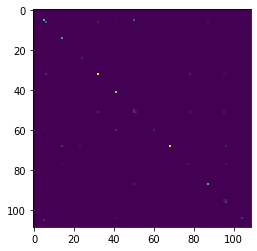

In [164]:
confusion_mat = confusion_matrix(tag_true, tag_pred, labels=list(range(109)))
plt.imshow(confusion_mat)

<StemContainer object of 3 artists>

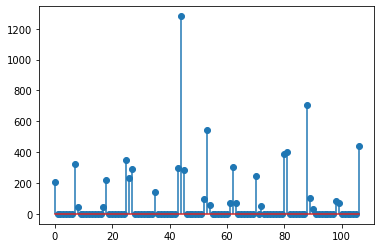

In [165]:
plt.stem(shear_mat(confusion_mat[:-1, :-1]).sum(axis=0)[1:], use_line_collection=True)

In [114]:
print(classification_report(tag_true, tag_pred))

              precision    recall  f1-score   support

           5       0.79      0.66      0.72      3241
           6       0.69      0.62      0.65      1500
          14       0.73      1.00      0.85      1922
          23       0.00      0.00      0.00         0
          24       0.87      0.97      0.91       315
          32       0.84      0.74      0.79      4092
          41       0.80      0.99      0.89      2557
          50       0.25      1.00      0.39       541
          51       0.72      0.18      0.29      1528
          59       0.00      0.00      0.00         0
          60       0.89      0.33      0.49       873
          68       0.95      0.70      0.81      3883
          77       0.94      0.26      0.40       630
          78       0.00      0.00      0.00         0
          87       0.89      0.84      0.87      2396
          95       0.35      0.47      0.40       542
          96       0.47      1.00      0.64       635
         104       0.90    

In [116]:
tonic_true = []
tonic_pred = []
for step in range(validation_size):
    x, y_true = next(gen_val)
    tonic_true.extend(y_true[1].squeeze())
    
    tag_pred_dense, tonic_pred_dense, profile_pred = model.predict(x)
    tonic_pred.extend(np.argmax(tonic_pred_dense, axis=2).squeeze())


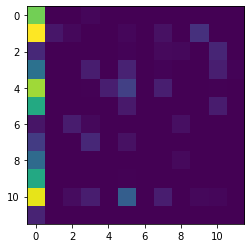

In [166]:
confusion_mat = confusion_matrix(tonic_true, tonic_pred, labels=list(range(13)))
plt.imshow(shear_mat(confusion_mat[:-1, :-1]))

(0, 12)

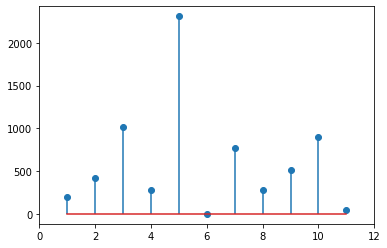

In [173]:
plt.stem(range(1,12), shear_mat(confusion_mat[:-1, :-1]).sum(axis=0)[1:], use_line_collection=True)
plt.xlim(0, 12)

In [134]:
arr = np.ones((1,))

In [135]:
arr.sum()

array([[1., 1., 1., 1.]])

In [118]:
print(classification_report(tonic_true, tonic_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      2557
           1       0.86      0.78      0.82      4092
           2       0.48      0.41      0.44       873
           3       0.47      0.57      0.52      2069
           4       0.97      0.70      0.81      3883
           5       0.88      0.81      0.84      2396
           6       0.37      0.29      0.33       630
           7       0.81      0.53      0.64      1041
           8       0.52      0.93      0.67      1177
           9       0.72      0.99      0.83      1922
          10       0.73      0.64      0.69      4741
          11       0.55      1.00      0.71       315

    accuracy                           0.74     25696
   macro avg       0.68      0.72      0.68     25696
weighted avg       0.76      0.74      0.74     25696



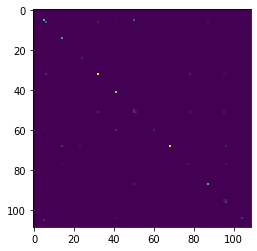

In [89]:
plt.imshow(output)

In [132]:
shear_mat(confusion_mat)

array([[2496,    0,    0,   61,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  72,   10,    2,   59,    0,  137,    0,  445,    0,    0,    0,
        3172,  195],
       [   0,   35,    0,   83,   67,    0,    0,  326,    0,  362,    0,
           0,    0],
       [   0,   35,    0,    0,    0,  262,   36, 1181,    0,    0,  248,
           4,  303],
       [   0,    0,    0,   15,   11, 2715,    0,    2,   16,  268,  595,
           0,  261],
       [   0,  242,    0, 1930,    0,    0,    8,    0,  216,    0,    0,
           0,    0],
       [   0,  185,    0,  245,   65,    0,    0,    0,    0,    0,  135,
           0,    0],
       [   0,    0,  347,    0,    0,  143,    0,    0,    0,    0,    0,
           0,  551],
       [   0,    0,    0,    0,    0,    0,   77,    0,    0,    0, 1100,
           0,    0],
       [   0,   13,    0,    0,    0,    0,    0,    0, 1909,    0,    0,
           0,    0],
       [   0,  259,    0,   73,   51,    0, 3051, 

In [78]:
tag_pred[0].shape

(369, 109)

In [65]:
y_true[0].ndim

(1, 421, 1)

In [62]:
np.argmax(tag_pred[:, 0, :])

14

In [63]:
y_true[0][:, 0, :]

array([[14]])